In [6]:
## imports
import numpy as np
from matplotlib import pyplot as plt
from struct import unpack
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import modeling
import time
import numpy.matlib
%matplotlib widget


In [7]:
## path to datase and number of timestamps 
lines_of_data = 512

filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221028_calibration/acq_221028_171552_calibration.dat" # calibration dataset


In [8]:
# Read data file 

st = time.time()

rawFile = np.fromfile(filename, dtype=np.uint32) # read data 
data = ((rawFile & 0xFFFFFFF).astype(np.longlong))% 140   # Mask upper bits as they are not used make module 140 to obtain TDC data    
data[np.where(rawFile < 0x80000000)] = -1 # Mask not valid data 
nmrCycles = int(len(data) / lines_of_data / 256)  # number of cycles,
data_matrix = data.reshape((lines_of_data,nmrCycles*256), order='F').reshape((lines_of_data, 256,-1),order='F').transpose((0,2,1)).reshape((-1, 256),order='F').transpose() # reshape the matrix
    
et = time.time()
print('Execution time:', et - st, 'seconds')

Execution time: 4.140084266662598 seconds


In [9]:
# Calibration matrix generation
st = time.time()

tdccal_arr = np.zeros((256,140)) # Create zero calibration matrix
bins = np.arange(0, 141, 1) # create 141 bins -> after histogram it generates 140 counts

# create calibration matrix
for i in range(256):
    counts, bin_edges= np.histogram(data_matrix[i], bins=bins)
    tdccal_arr[i] = np.cumsum(counts)/np.cumsum(counts).max()*2500

et = time.time()
print('Execution time:', et - st, 'seconds')

np.save('tdccal_arr.npy',tdccal_arr)

Execution time: 12.37829852104187 seconds


In [5]:
##  Try the calibration
lines_of_data = 512
filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221021/acq_221021_202311_timeStamps512.dat" # 135 143
# filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221021/pixel_movement/acq_221021_212530_135_171.dat" # DONE OK
# filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221021/acq_221021_202311_timeStamps512.dat"
# filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221018/no_delay/acq_221018_230939.dat"

rawFile = np.fromfile(filename, dtype=np.uint32) # read data 
data = ((rawFile & 0xFFFFFFF).astype(np.longlong))*1.0   # Multiply with the lowes bin   
data[np.where(rawFile < 0x80000000)] = -1 # Mask not valid data 
nmrCycles = int(len(data) / lines_of_data / 256)  # number of cycles,
data_matrix = data.reshape((lines_of_data,nmrCycles*256), order='F').reshape((lines_of_data, 256,-1),order='F').transpose((0,2,1)).reshape((-1, 256),order='F').transpose() # reshape the matrix


In [32]:
# Calibrate whole matrix i.e data_matrix

#load offset
offsets_arr = np.load('offsets_arr.npy')
tdccal_arr = np.load('tdccal_arr.npy')

timestampsnmr = lines_of_data
nmr_of_cycles = int(len(data_matrix[0,:]) / timestampsnmr)

offset = np.zeros(256)

for i in range(256):
    ind = np.argwhere(data_matrix[i,:] >= 0)
    data_matrix[i,ind] = (data_matrix[i,ind] - (data_matrix[i,ind] % 140))*17.857 +  tdccal_arr[i,(data_matrix[i,ind] % 140).astype(int)] + offsets_arr[i]

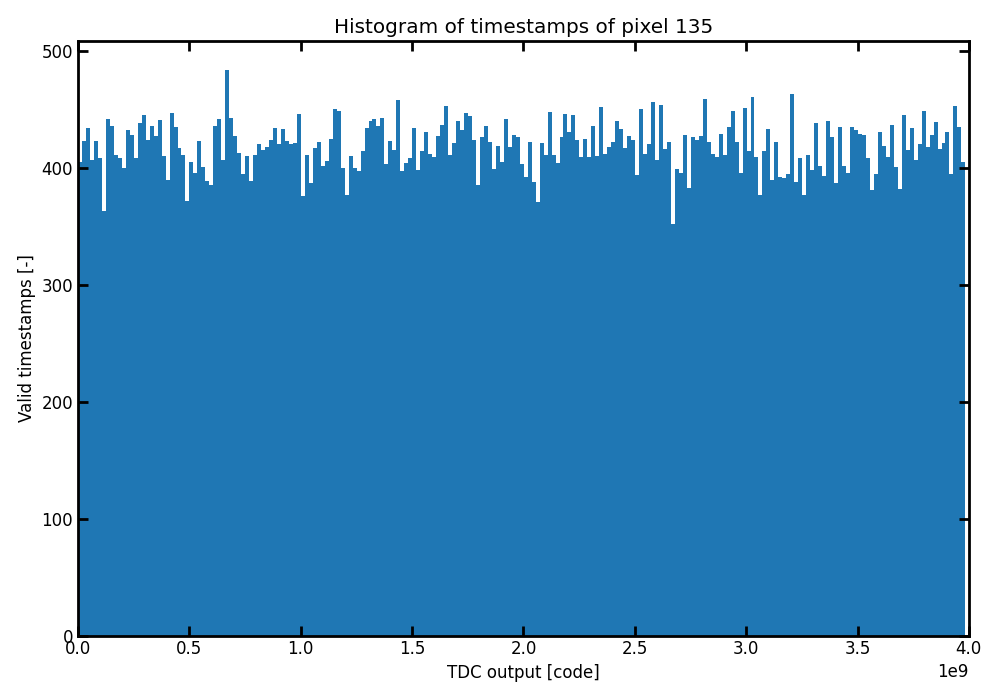

In [17]:


pixel_nmr = 135
fig, ax = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

bins = np.arange(0, 4e9, 17.867*1e6)
pixel_data = data_matrix[pixel_nmr]

ax.tick_params(which="both", width=2, direction="in")
ax.tick_params(which="major", length=7, direction="in")
ax.tick_params(which="minor", length=4, direction="in")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("TDC output [code]")
ax.set_ylabel("Valid timestamps [-]")
ax.set_title("Histogram of timestamps of pixel {}".format(pixel_nmr))
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)
counts, binshist, bars = ax.hist(pixel_data, bins=bins)

ax.set_xlim(0, 4e9)
plt.show()   


In [33]:
## Compute delta t for two pixels 

# Set peak postion
p0 = 135
p1 = 143

pixel_0 = data_matrix[p0]
pixel_1 = data_matrix[p1]

timewindow = 30000
timestampsnmr = lines_of_data
nmr_of_cycles = int(len(pixel_0) / timestampsnmr)
delta_t = []

# start = time.time()
for cycle in range(nmr_of_cycles):
    for timestamp_pix0 in range(timestampsnmr):
        pix_0 = pixel_0[cycle * timestampsnmr + timestamp_pix0]
        if pix_0 == -1:
            break
        for timestamp_pix1 in range(timestampsnmr):
            pix_1=pixel_1[cycle * timestampsnmr + timestamp_pix1] 
            if pix_1 == -1 or pix_1 == 0:
                break
            if np.abs(pix_0 - pix_1) < timewindow:
                delta_t.append(pix_0 - pix_1)
            else:
                continue

NMR of coincidences in window: 176


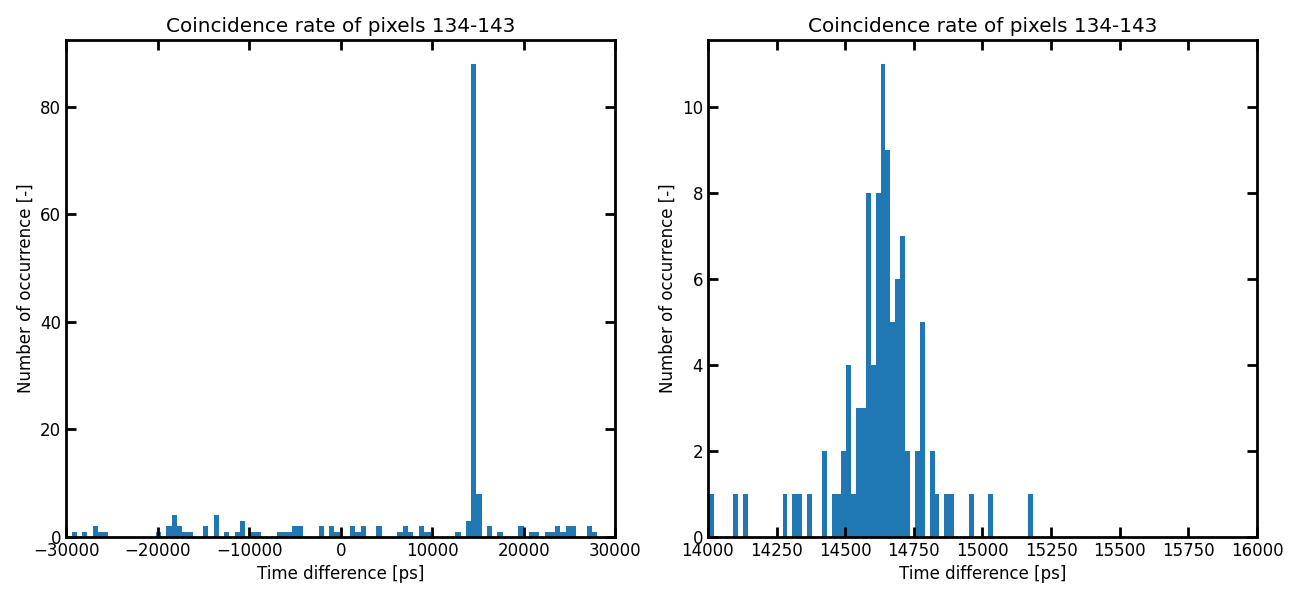

In [39]:
## Plot delta_t computed in previous code

fig, ax = plt.subplots(1,2)

plt.rcParams.update({"font.size": 12})
x = np.arange(0, 256, 1)

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")

plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(13, 6)

for i in range(2):
    ax[i].tick_params(which="both", width=2, direction="in")
    ax[i].tick_params(which="major", length=7, direction="in")
    ax[i].tick_params(which="minor", length=4, direction="in")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")
    ax[i].set_xlabel("Time difference [ps]")
    ax[i].set_ylabel("Number of occurrence [-]")
    ax[i].set_title("Coincidence rate of pixels {}-{}".format(p0,p1))
    
for axis in ["top", "bottom", "left", "right"]:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

bins = np.arange(np.min(delta_t), np.max(delta_t), 17.857) #
# bins = 100
bins2 = np.arange(np.min(delta_t), np.max(delta_t), 50 )
ax[0].hist(delta_t, bins=100)
ax[1].hist(delta_t, bins=bins, label='data')
ax[0].set_xlim(-timewindow, timewindow)

# Set limits of right plot
ax[1].set_xlim(14000, 16000)

fig.tight_layout(pad=1.0)

print("NMR of coincidences in window: " + str(len(delta_t)))

The sum under the peak is 67


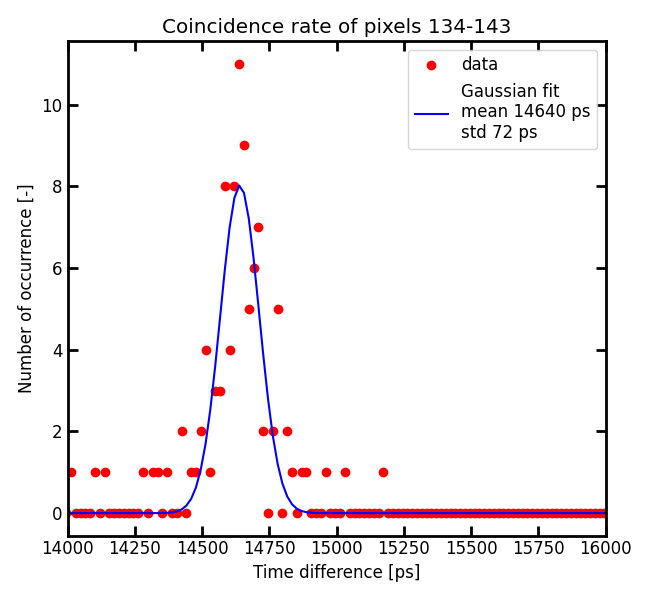

In [40]:
## Fit coincidence rate with gaussian 

bins = np.arange(np.min(delta_t), np.max(delta_t), 17.857 )

counts, binEdges=np.histogram(delta_t,bins=bins)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

n_max = np.argmax(counts)
arg_max = (binEdges[n_max] + binEdges[n_max + 1]) / 2
sigma = 200

parameters, covariance = curve_fit(gauss, binCenters, counts,p0=[max(counts), arg_max, sigma])

fit_y = gauss(binCenters, parameters[0], parameters[1], parameters[2])

## Plots
fig, ax = plt.subplots(1, 1, figsize=(6.5, 6), tight_layout=True)
ax.tick_params(which="both", width=2, direction="in")
ax.tick_params(which="major", length=7, direction="in")
ax.tick_params(which="minor", length=4, direction="in")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Time difference [ps]")
ax.set_ylabel("Number of occurrence [-]")
ax.set_title("Coincidence rate of pixels {}-{}".format(p0,p1))
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)
plt.xlim(14000, 16000)
ax.plot(binCenters, counts, 'ro', label='data')
ax.plot(binCenters, fit_y, 'b-', label="Gaussian fit \nmean {} ps\nstd {} ps".format(int(np.round(parameters[1])),int(np.round(parameters[2]))))
ax.legend()

print("The sum under the peak is " + str(np.sum(counts[n_max-6:n_max+6])))
